<a href="https://colab.research.google.com/github/nyinyi979/AI-BE/blob/test/fashionMNIST_FGSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report




In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
#create data transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

#check and set GPU/CPU based on availability
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

# download and load FashionMNIST
train_data  = datasets.FashionMNIST(root="./data", download=True, train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

test_data  = datasets.FashionMNIST(root="./data", download=True, train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.54MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
X_, _ = next(iter(train_dataloader))
X_.shape

torch.Size([64, 1, 28, 28])

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [7]:
eps = [0, 0.05, .1,.15, .2, .25, .3]

In [8]:
#Crate CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #12, 12, 10
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #4, 4, 20
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Epoch 0, Loss: 2.319012  [   64/60000]
Epoch 0, Loss: 0.998246  [32064/60000]
Epoch 1, Loss: 0.889173  [   64/60000]
Epoch 1, Loss: 0.673708  [32064/60000]
Epoch 2, Loss: 0.773017  [   64/60000]
Epoch 2, Loss: 0.619625  [32064/60000]
Epoch 3, Loss: 0.555645  [   64/60000]
Epoch 3, Loss: 0.499833  [32064/60000]
Epoch 4, Loss: 0.411262  [   64/60000]
Epoch 4, Loss: 0.521698  [32064/60000]


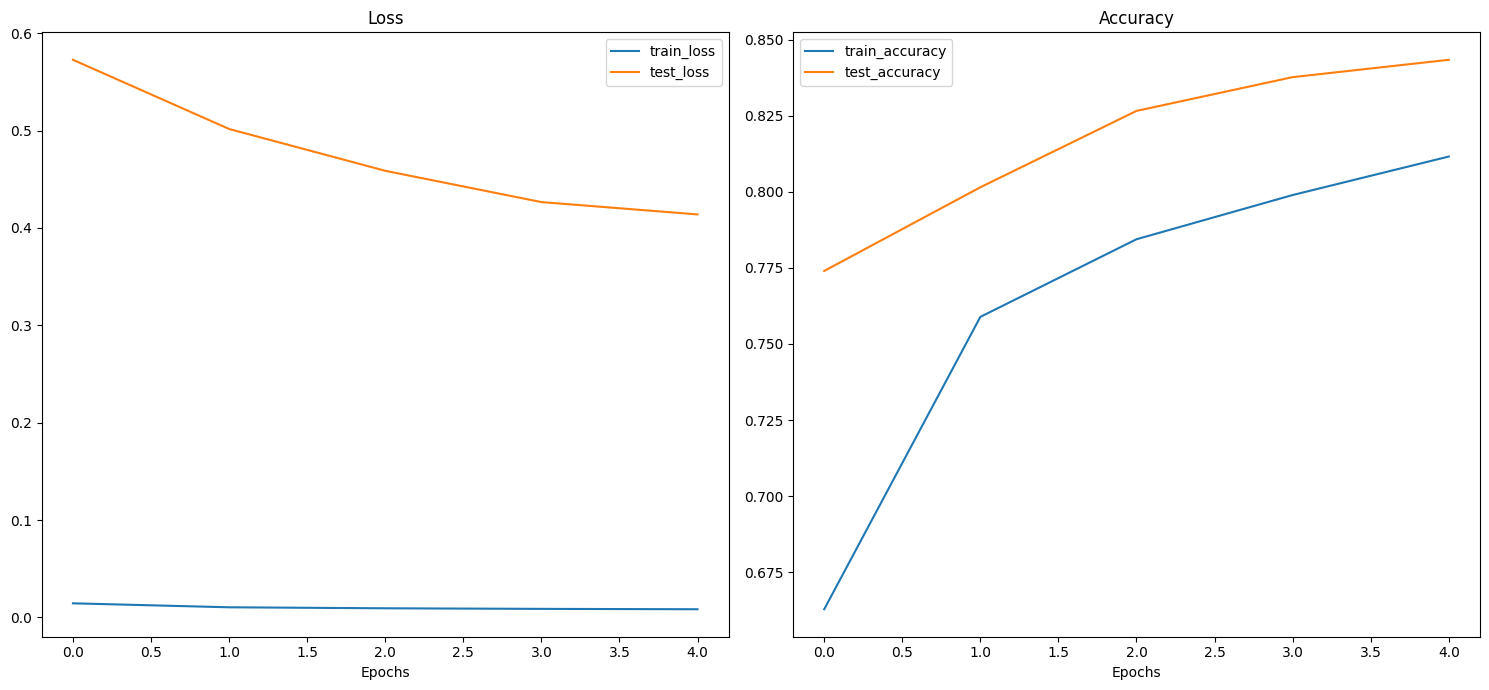

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import Dict, List


device = "cuda" if torch.cuda.is_available() else "cpu"

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()  # Set the model to evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad():  # Disable gradient computation during evaluation
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()
    test_loss /= size
    accuracy = correct / size
    return test_loss, accuracy

def train_loop(dataloader, model, loss_fn, optimizer, epoch, results):
    size = len(dataloader.dataset)
    model.train()  # Set the model to training mode
    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()

        if batch % 500 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Epoch {epoch}, Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= size
    accuracy = correct / size

    # Store the results for plotting
    results['train_loss'].append(train_loss)
    results['train_acc'].append(accuracy)

    # Test the model after every epoch
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_accuracy)

    return results

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model and track the results
model = CNN().to(device)
learning_rate = 1e-3
batch_size = 64
epochs = 5

train_loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Dictionary to store results
results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

# Training loop
for epoch in range(epochs):
    results = train_loop(train_dataloader, model, train_loss_fn, optimizer, epoch, results)

# After training, plot the loss and accuracy curves
plot_loss_curves(results)


In [12]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1, keepdim=True)  # Get the index of the max log-softmax probability
            correct += predicted.eq(target.view_as(predicted)).sum().item()  # Count correct predictions
            total += target.size(0)

    accuracy = correct / total  # Calculate accuracy
    return accuracy


In [13]:
accuracy = evaluate_accuracy(model, test_dataloader, device)
accuracy

0.8434

In [14]:
# Save the model
torch.save(model.state_dict(), "fashion_mnist_cnn.pth")
print("Model saved successfully!")

Model saved successfully!


In [15]:
model.eval()

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [16]:
def FGSM_attack(image, eps, data_grad):
  sign_ = data_grad.sign()
  noise_img = image + eps*(sign_)
  noise_img = torch.clamp(noise_img, 0, 1)
  return noise_img

In [17]:
def test(model, device, test_dataloader, eps):

  correct =0
  adv_examples = []

  for data, label in test_dataloader:

    data, label = data.to(device), label.to(device)

    data.requires_grad = True
    output = model(data)
    initial_pred = output.max(1, keepdim=True)[1] #index of max log-sftmx prob

    if initial_pred.item()!=label.item(): continue
    loss = F.nll_loss(output, label)

    model.zero_grad()
    loss.backward()

    data_grad = data.grad.data

    noisy_image = FGSM_attack(data, eps, data_grad)
    new_output = model(noisy_image)

    #check if this was a successful adversial data
    new_pred = new_output.max(1, keepdim=True)[1]
    if new_pred.item() == label.item():
      correct+=1
      # Special case for saving 0 epsilon examples
      if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = noisy_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (initial_pred.item(), new_pred.item(), adv_ex) )

    else:
      if len(adv_examples) < 5:
          adv_ex = noisy_image.squeeze().detach().cpu().numpy()
          adv_examples.append( (initial_pred.item(), new_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_dataloader))
  print(f"Epsilon: {eps}\tTest Accuracy = {correct} / {len(test_dataloader)} = {final_acc*100:.2f}%")

  return final_acc, adv_examples

In [19]:
accuracies = []
examples = []

# Run test for each epsilon
for ep in eps:
    acc, ex = test(model, device, test_dataloader, ep)
    accuracies.append(acc)
    examples.append(ex)


Epsilon: 0	Test Accuracy = 8434 / 10000 = 84.34%
Epsilon: 0.05	Test Accuracy = 5031 / 10000 = 50.31%
Epsilon: 0.1	Test Accuracy = 2159 / 10000 = 21.59%
Epsilon: 0.15	Test Accuracy = 1186 / 10000 = 11.86%
Epsilon: 0.2	Test Accuracy = 623 / 10000 = 6.23%
Epsilon: 0.25	Test Accuracy = 290 / 10000 = 2.90%
Epsilon: 0.3	Test Accuracy = 110 / 10000 = 1.10%


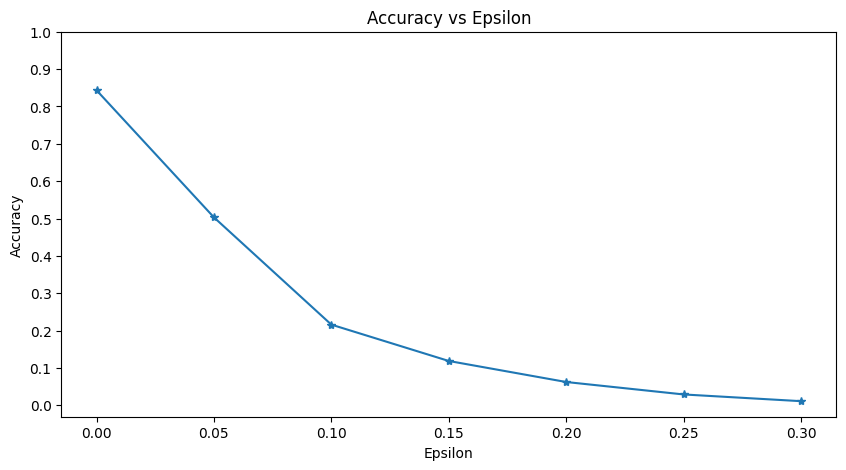

In [20]:
plt.figure(figsize=(10,5))
plt.plot(eps, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

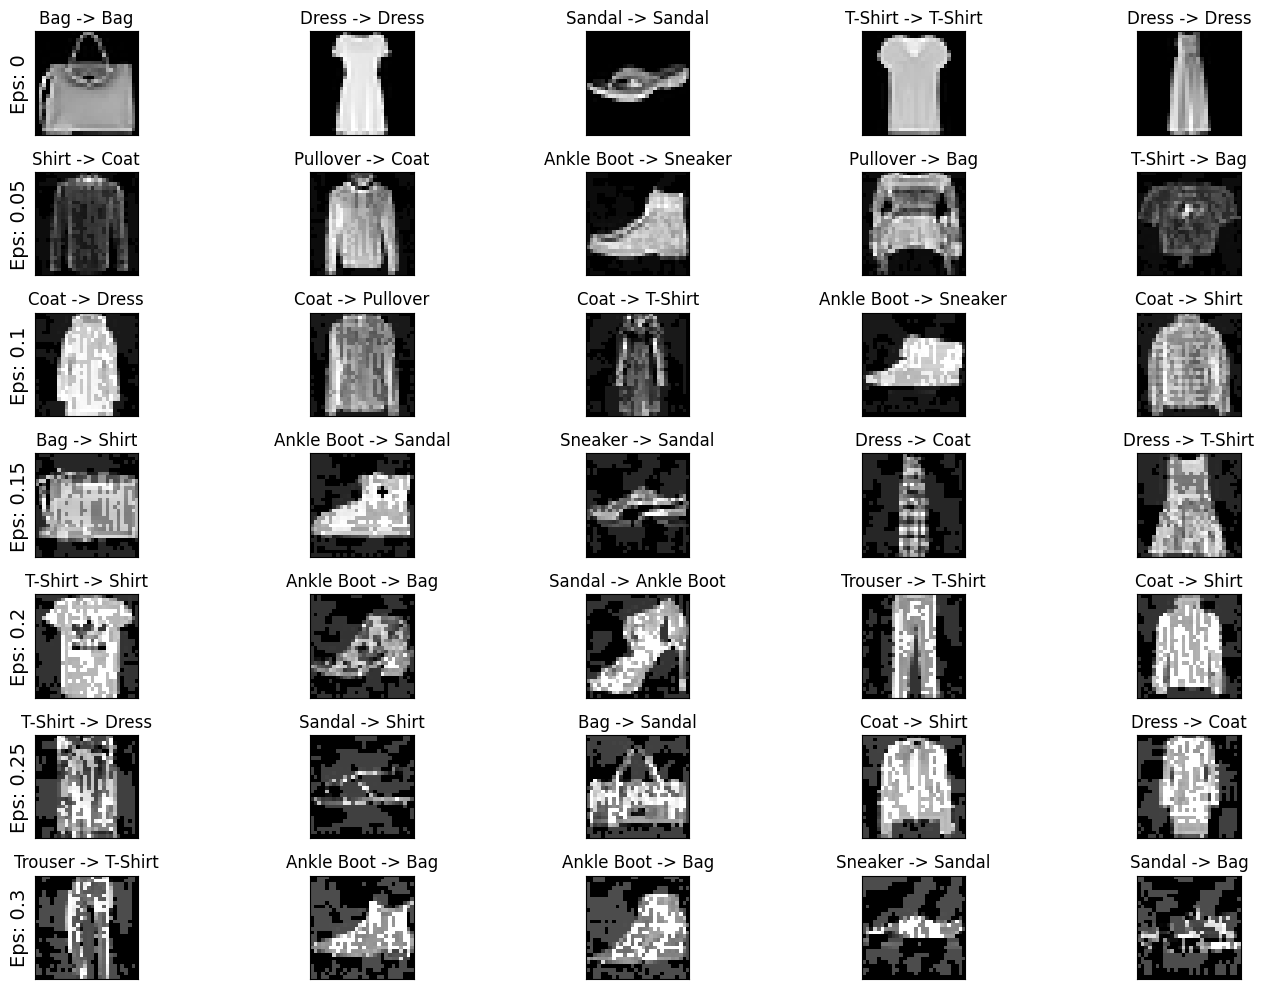

In [21]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(15,10))
for i in range(len(eps)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(eps),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(eps[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{labels_map[orig]} -> {labels_map[adv]}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Accuracy Before Attack: 84.34%


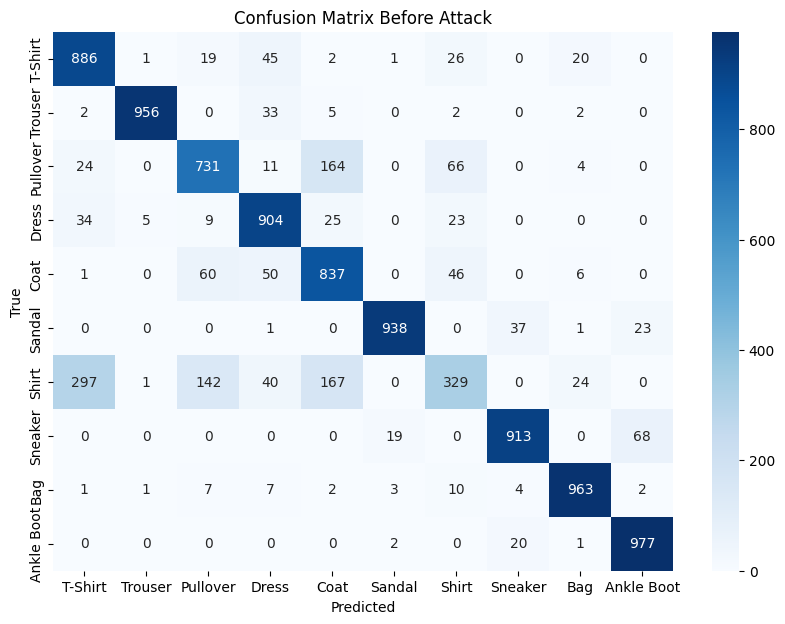


Classification Report Before Attack:
              precision    recall  f1-score   support

     T-Shirt       0.71      0.89      0.79      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.76      0.73      0.74      1000
       Dress       0.83      0.90      0.86      1000
        Coat       0.70      0.84      0.76      1000
      Sandal       0.97      0.94      0.96      1000
       Shirt       0.66      0.33      0.44      1000
     Sneaker       0.94      0.91      0.93      1000
         Bag       0.94      0.96      0.95      1000
  Ankle Boot       0.91      0.98      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.83     10000
weighted avg       0.84      0.84      0.83     10000



In [22]:
# Evaluation before attack
from sklearn.metrics import confusion_matrix

def evaluate_before_attack(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)

            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Collect all predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Accuracy Before Attack: {accuracy:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map.values(), yticklabels=labels_map.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Before Attack')
    plt.show()

    # Classification report
    print("\nClassification Report Before Attack:")
    print(classification_report(all_labels, all_preds, target_names=labels_map.values()))

    return accuracy, cm

# Run evaluation before the attack
accuracy_before, cm_before = evaluate_before_attack(model, test_dataloader, device)


Accuracy After Attack (epsilon=0.05): 56.68%


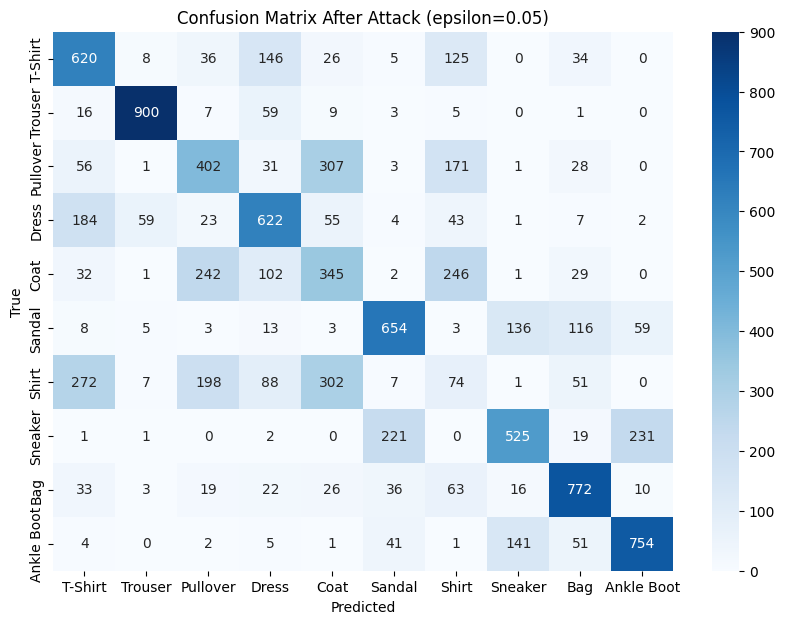


Classification Report After Attack:
              precision    recall  f1-score   support

     T-Shirt       0.51      0.62      0.56      1000
     Trouser       0.91      0.90      0.91      1000
    Pullover       0.43      0.40      0.42      1000
       Dress       0.57      0.62      0.60      1000
        Coat       0.32      0.34      0.33      1000
      Sandal       0.67      0.65      0.66      1000
       Shirt       0.10      0.07      0.09      1000
     Sneaker       0.64      0.53      0.58      1000
         Bag       0.70      0.77      0.73      1000
  Ankle Boot       0.71      0.75      0.73      1000

    accuracy                           0.57     10000
   macro avg       0.56      0.57      0.56     10000
weighted avg       0.56      0.57      0.56     10000



In [23]:
# Evaluation after FGSM attack
def evaluate_after_attack(model, test_dataloader, device, eps):
    model.train()  # Set model to training mode to allow gradient computation
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Disable gradient computation for evaluation, but we need it for adversarial attack
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)

        # Ensure that the data tensor requires gradients
        data.requires_grad = True

        # Forward pass to get output and calculate loss
        output = model(data)
        loss = F.nll_loss(output, target)

        # Backpropagate to compute gradients
        model.zero_grad()
        loss.backward()

        # Get the gradients of the data
        data_grad = data.grad.data

        # Create adversarial example
        noisy_image = FGSM_attack(data, eps, data_grad)

        # Evaluate the model with the adversarial image
        output_adv = model(noisy_image)
        _, predicted = torch.max(output_adv, 1)

        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Collect all predictions and labels for confusion matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Accuracy After Attack (epsilon={eps}): {accuracy:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map.values(), yticklabels=labels_map.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix After Attack (epsilon={eps})')
    plt.show()

    # Classification report
    print("\nClassification Report After Attack:")
    print(classification_report(all_labels, all_preds, target_names=labels_map.values()))

    return accuracy, cm

# Run evaluation after the attack
eps = 0.05  # Attack with epsilon = 0.05
accuracy_after, cm_after = evaluate_after_attack(model, test_dataloader, device, eps)


Accuracy Before Attack: 84.34%
Accuracy After Attack: 56.68%


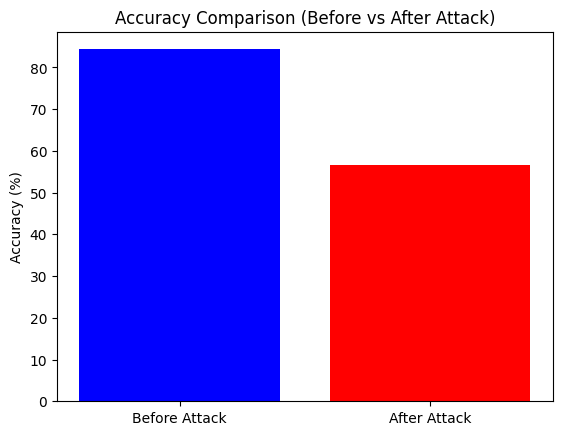

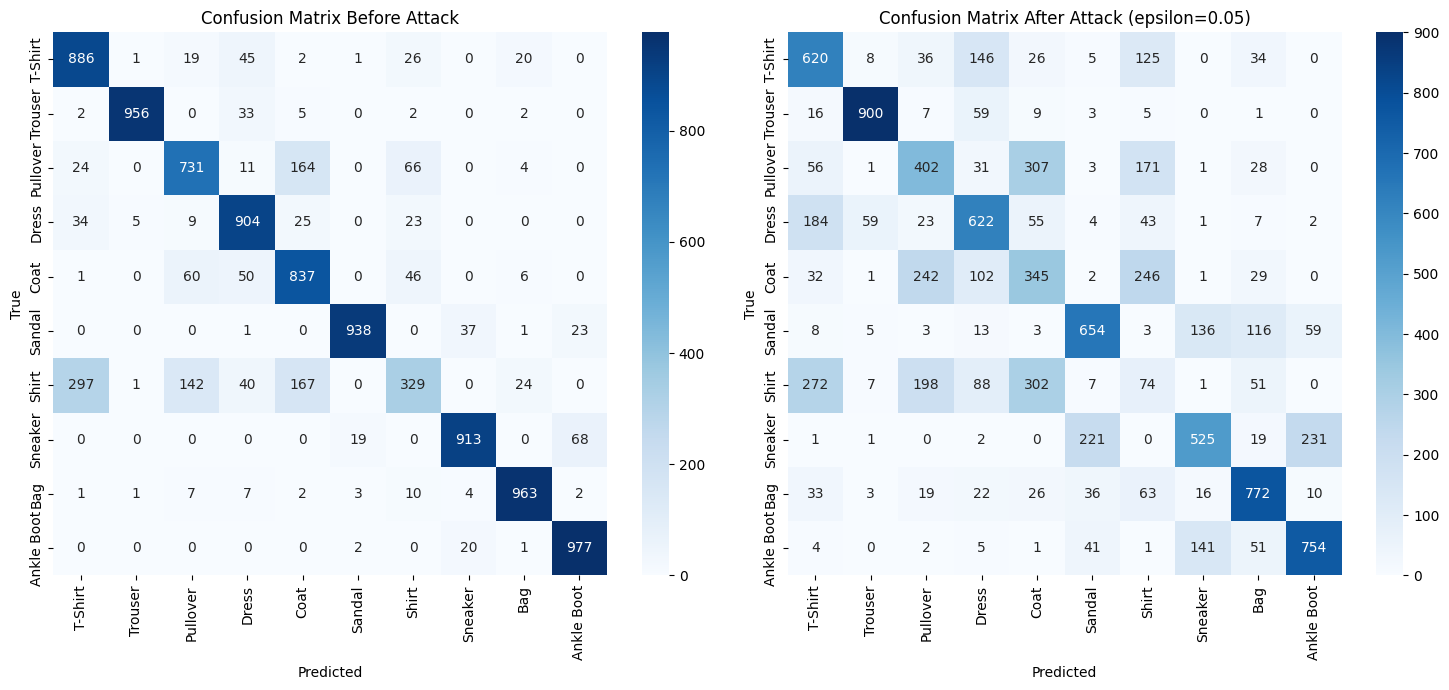

In [24]:
# Compare accuracies before and after the attack
print(f"Accuracy Before Attack: {accuracy_before:.2f}%")
print(f"Accuracy After Attack: {accuracy_after:.2f}%")

# You can also plot the difference in accuracies
plt.bar(["Before Attack", "After Attack"], [accuracy_before, accuracy_after], color=['blue', 'red'])
plt.title("Accuracy Comparison (Before vs After Attack)")
plt.ylabel("Accuracy (%)")
plt.show()

# Optionally, compare confusion matrices visually by plotting both side by side
plt.figure(figsize=(15, 7))

# Plot confusion matrix before the attack
plt.subplot(1, 2, 1)
sns.heatmap(cm_before, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Before Attack')

# Plot confusion matrix after the attack
plt.subplot(1, 2, 2)
sns.heatmap(cm_after, annot=True, fmt="d", cmap="Blues", xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix After Attack (epsilon={eps})')

plt.tight_layout()
plt.show()


In [25]:
# Create a new instance of the model
model_new = CNN().to(device)

# Load the saved model
model_new.load_state_dict(torch.load("fashion_mnist_cnn.pth"))
model_new.eval()  # Set the model to evaluation mode
print("Model loaded successfully!")


Model loaded successfully!


<ipython-input-25-45b9e25ad7ba>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load("fashion_mnist_cnn.pth"))


Epoch 1/5
Batch 0: Loss 1.2032787799835205
Batch 500: Loss 0.9753813743591309
Epoch 1 - Loss: 0.8344, Accuracy: 69.04%
Epoch 2/5
Batch 0: Loss 1.155797004699707
Batch 500: Loss 0.8028950691223145
Epoch 2 - Loss: 0.7721, Accuracy: 70.86%
Epoch 3/5
Batch 0: Loss 0.6954396367073059
Batch 500: Loss 0.6766397953033447
Epoch 3 - Loss: 0.7520, Accuracy: 71.52%
Epoch 4/5
Batch 0: Loss 0.9135611057281494
Batch 500: Loss 0.680625319480896
Epoch 4 - Loss: 0.7389, Accuracy: 72.02%
Epoch 5/5
Batch 0: Loss 1.000275731086731
Batch 500: Loss 0.941143274307251
Epoch 5 - Loss: 0.7232, Accuracy: 72.62%


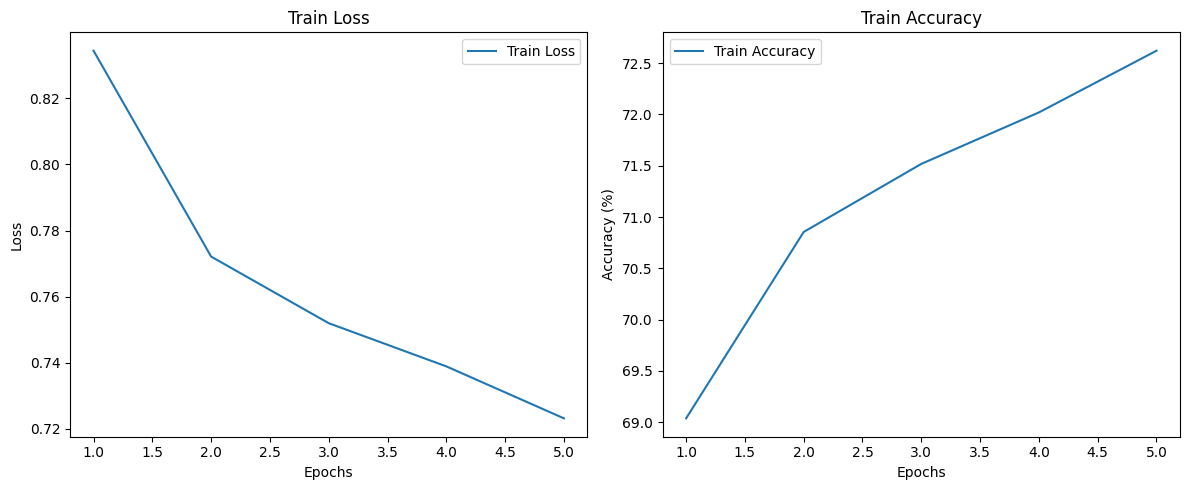

In [26]:
# Train with adversarial defense using FGSM (epsilon = 0.05)
def train_with_defense(model, dataloader, optimizer, loss_fn, eps, device, num_epochs=5):
    model.train()  # Set the model to training mode
    train_loss = []
    train_accuracy = []

    for epoch in range(num_epochs):  # Outer loop for epochs
        print(f"Epoch {epoch+1}/{num_epochs}")
        epoch_loss = 0
        correct = 0
        total = 0

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Perform FGSM attack on the input image
            X.requires_grad = True
            output = model(X)
            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()

            # Compute the gradient of the loss w.r.t. the input image
            data_grad = X.grad.data

            # Generate adversarial example=============>>>>>>>
            noisy_image = FGSM_attack(X, eps, data_grad)

            # Forward pass with the adversarial example
            optimizer.zero_grad()
            output_after_attack = model(noisy_image)
            loss_after_attack = loss_fn(output_after_attack, y)
            loss_after_attack.backward()
            optimizer.step()

            epoch_loss += loss_after_attack.item()

            # Calculate accuracy for this batch
            _, predicted = torch.max(output_after_attack, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

            if batch % 500 == 0:
                print(f"Batch {batch}: Loss {loss_after_attack.item()}")

        # Calculate and store loss and accuracy for the epoch
        avg_loss = epoch_loss / len(dataloader)
        accuracy = 100 * correct / total
        train_loss.append(avg_loss)
        train_accuracy.append(accuracy)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Plot loss and accuracy after training
    plot_loss_accuracy(train_loss, train_accuracy)

# Plot training loss and accuracy
def plot_loss_accuracy(train_loss, train_accuracy):
    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the optimizer for the new model
optimizer_new = torch.optim.Adam(model_new.parameters(), lr=1e-3)
loss_fn = nn.NLLLoss()

# Train the new model with adversarial defense (epsilon = 0.05) for 5 epochs
train_with_defense(model_new, train_dataloader, optimizer_new, loss_fn, eps=0.05, device=device, num_epochs=5)


In [27]:
# Evaluate the original model after attack
eps = 0.05  # Attack with epsilon = 0.05
accuracy_after_attack, _ = test(model, device, test_dataloader, eps)
accuracy_percentage_after_attack = accuracy_after_attack * 100
print(f"Original model accuracy after attack with epsilon {eps}: {accuracy_percentage_after_attack:.2f}%")


Epsilon: 0.05	Test Accuracy = 5464 / 10000 = 54.64%
Original model accuracy after attack with epsilon 0.05: 54.64%


In [35]:
# Evaluate the new model (defended) after training
accuracy_after_defense, _ = test(model_new, device, test_dataloader, eps)
accuracy_percentage_after_defense = accuracy_after_defense * 100
print(f"Defended model accuracy after attack with epsilon {eps}: {accuracy_percentage_after_defense:.2f}%")


Epsilon: 0.05	Test Accuracy = 7084 / 10000 = 70.84%
Defended model accuracy after attack with epsilon 0.05: 70.84%


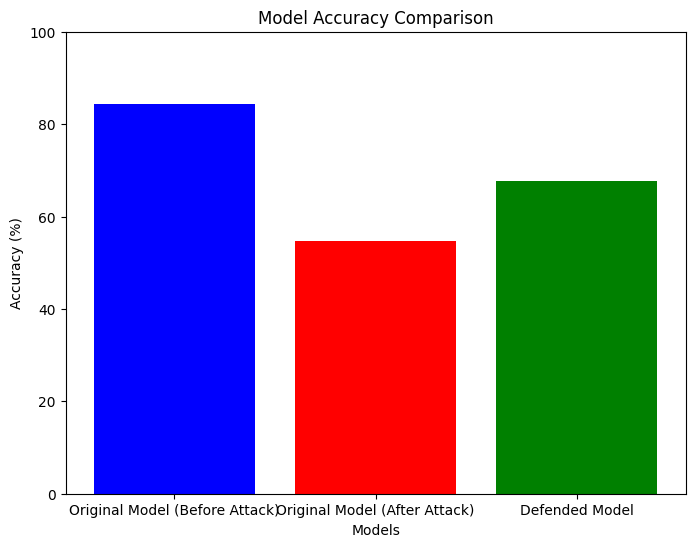

In [29]:
import matplotlib.pyplot as plt

# Comparison of accuracies
labels = ['Original Model (Before Attack)', 'Original Model (After Attack)', 'Defended Model']
accuracies = [
    accuracy_before,  # Accuracy before attack
    accuracy_percentage_after_attack,  # Accuracy after attack for the original model
    accuracy_percentage_after_defense  # Accuracy after attack for the defended model
]

# Plot the comparison
plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'red', 'green'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()


In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate and generate confusion matrix for a model
def generate_confusion_matrix(model, device, dataloader, eps=0.05):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []

    # Loop over the test dataset
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        # Perform FGSM attack
        data.requires_grad = True
        output = model(data)
        _, pred = output.max(1)  # Get the predicted labels

        # Store true and predicted labels
        true_labels.extend(target.cpu().numpy())
        pred_labels.extend(pred.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    return cm


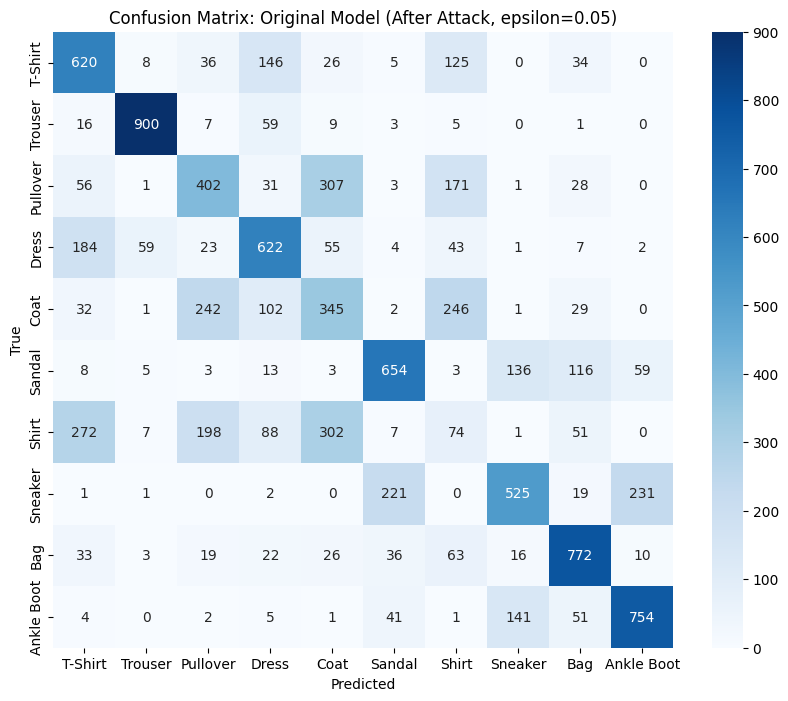

In [31]:
# Evaluate the original model after the attack (epsilon = 0.05)
eps = 0.05

# Plot confusion matrix for original model after attack
plt.figure(figsize=(10, 8))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.title(f"Confusion Matrix: Original Model (After Attack, epsilon={eps})")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


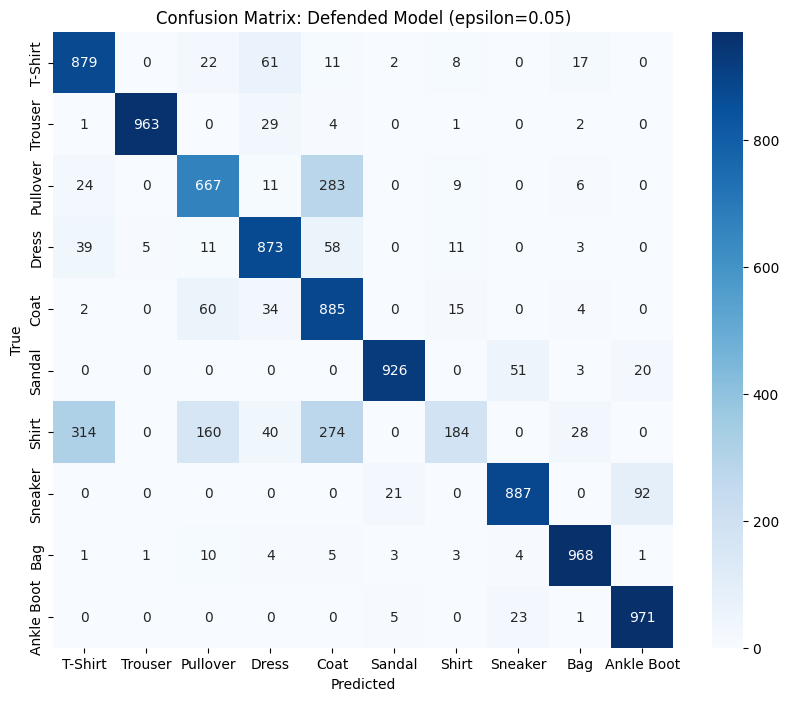

In [32]:
# Evaluate the defended model (epsilon = 0.05)
cm_after_defense = generate_confusion_matrix(model_new, device, test_dataloader, eps)

# Plot confusion matrix for defended model
plt.figure(figsize=(10, 8))
sns.heatmap(cm_after_defense, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.title(f"Confusion Matrix: Defended Model (epsilon={eps})")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


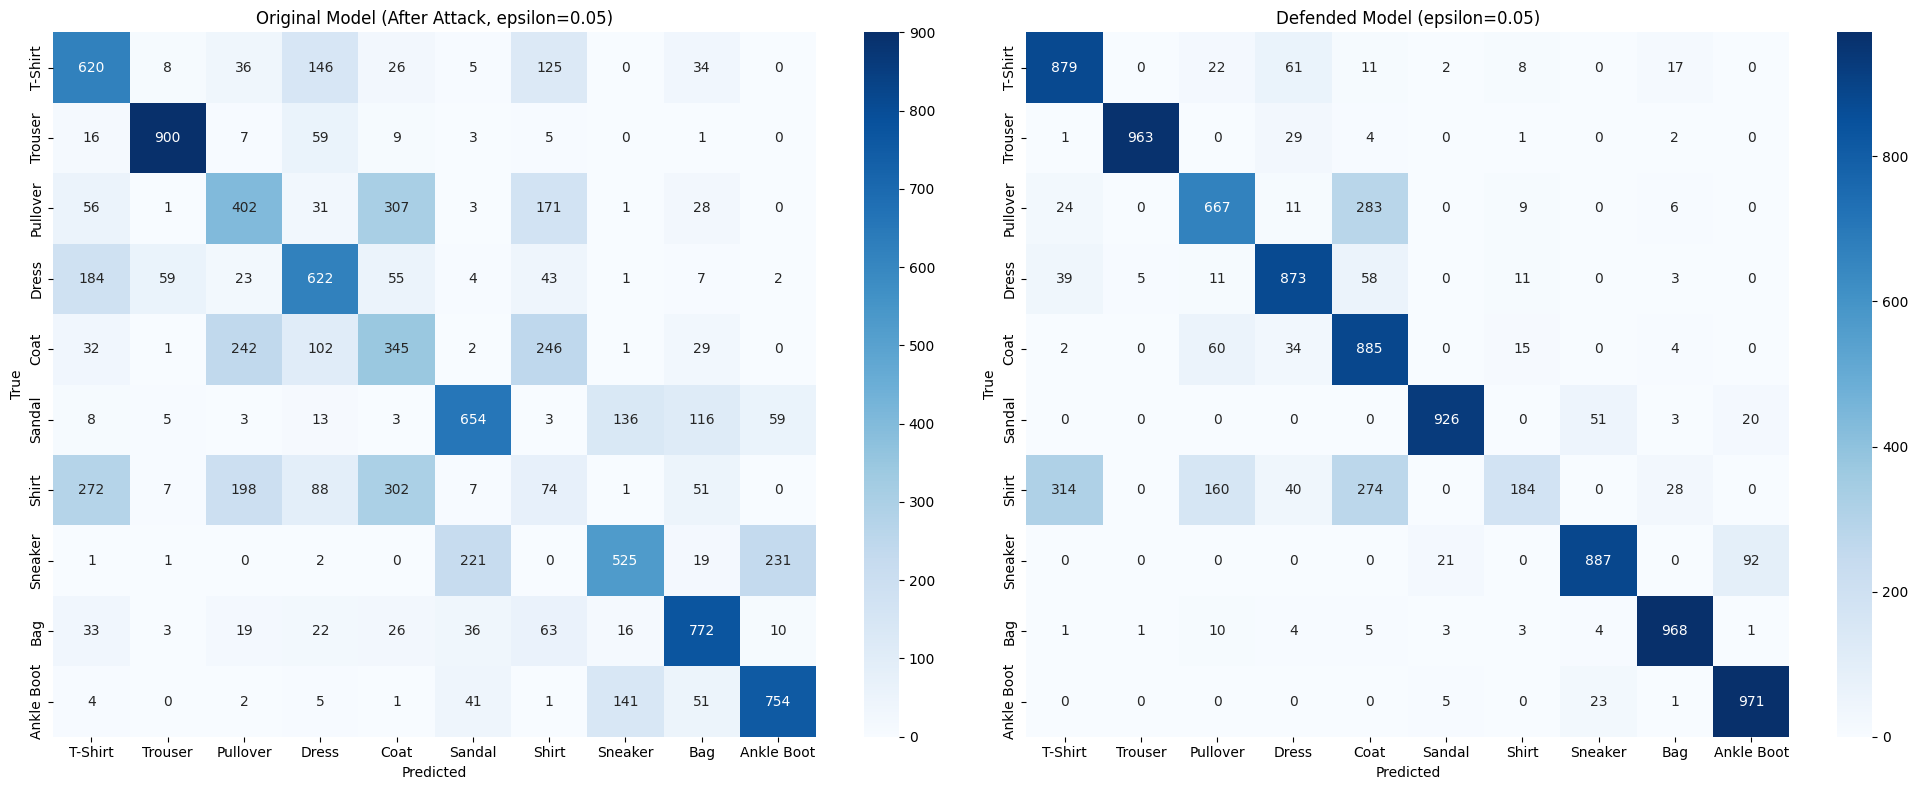

In [33]:
# Plot both confusion matrices for comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Original model (after attack) confusion matrix
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values(), ax=axes[0])
axes[0].set_title(f"Original Model (After Attack, epsilon={eps})")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Defended model confusion matrix
sns.heatmap(cm_after_defense, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values(), ax=axes[1])
axes[1].set_title(f"Defended Model (epsilon={eps})")
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()
